<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/Mechanism1_Logosfield_Rerun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Step 1: Upload the ZIP and extract it
import zipfile, os
from google.colab import files

print("📂 Please upload the ZIP file: Mechanism1_ScalarField_Rebuild_Files.zip")
uploaded = files.upload()

zip_name = next(iter(uploaded))
extract_dir = "/content/scalar_field_inputs"

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted files to {extract_dir}:")
for f in os.listdir(extract_dir):
    print("  -", f)


📂 Please upload the ZIP file: Mechanism1_ScalarField_Rebuild_Files.zip


Saving Mechanism1_ScalarField_Rebuild_Files (1).zip to Mechanism1_ScalarField_Rebuild_Files (1).zip
✅ Extracted files to /content/scalar_field_inputs:
  - spins 2.csv
  - nodes.csv
  - null_models_summary.csv
  - density.csv


In [10]:
# Step 2: Create a ZIP from extracted CSV files
import zipfile
import os
from google.colab import files

# Folder where files were extracted
extract_dir = "/content/scalar_field_inputs"
output_zip = "/content/ScalarField_SelectedCSVs.zip"

# List of target CSVs to include
selected_files = ["spins 2.csv", "nodes.csv", "density.csv", "null_models_summary.csv"]

# Create the ZIP
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for filename in selected_files:
        filepath = os.path.join(extract_dir, filename)
        if os.path.exists(filepath):
            zipf.write(filepath, arcname=filename)
        else:
            print(f"⚠️ Missing: {filename}")

print(f"✅ Created: {output_zip}")
files.download(output_zip)


✅ Created: /content/ScalarField_SelectedCSVs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# === REPRODUCE LOGOSFIELD SPIN ALIGNMENT: MECHANISM 1 (REVALIDATION CELL) ===
import pandas as pd, numpy as np
from scipy.spatial import cKDTree
from scipy.stats import binomtest
from math import radians, degrees, acos
import matplotlib.pyplot as plt
from google.colab import files

# === STEP 1: UPLOAD REQUIRED FILES ===
uploaded = files.upload()  # expects spin3.csv, nodes.csv, density2.csv

# === STEP 2: LOAD FILES ===
spin_df = pd.read_csv("spin3.csv")
nodes_df = pd.read_csv("nodes.csv")
density_df = pd.read_csv("density2.csv")

# === STEP 3: PREPARE SPIN CATALOG ===
spin_df = spin_df.rename(columns=lambda x: x.strip().lower())
spin_df = spin_df.dropna(subset=["ra", "dec", "spin"])
spin_df["spin"] = spin_df["spin"].astype(int)
spin_coords = np.radians(spin_df[["ra", "dec"]].to_numpy())

# === STEP 4: LOAD LOGOSFIELD NODES & DENSITY ===
nodes_df = nodes_df.rename(columns=lambda x: x.strip().lower())
density_df = density_df.rename(columns=lambda x: x.strip().lower())
nodes_xyz = nodes_df[["x", "y", "z"]].values
density_vals = density_df["density"].values

# === STEP 5: BUILD KDTREE FOR GRADIENT ESTIMATION ===
tree = cKDTree(nodes_xyz)
_, idxs = tree.query(nodes_xyz, k=8)  # nearest neighbors
grads = []
for neighbors in idxs:
    nbrs = nodes_xyz[neighbors]
    vals = density_vals[neighbors]
    A = np.c_[nbrs - nbrs[0]]
    b = vals - vals[0]
    grad, *_ = np.linalg.lstsq(A, b, rcond=None)
    grads.append(grad)
grads = np.array(grads)

# === STEP 6: COMPUTE GRADIENT VECTOR AT EACH SPIN LOCATION ===
from astropy.coordinates import SkyCoord
from astropy import units as u

node_coords = SkyCoord(x=nodes_xyz[:,0], y=nodes_xyz[:,1], z=nodes_xyz[:,2], representation_type='cartesian').spherical
node_radec = np.vstack([node_coords.ra.deg, node_coords.dec.deg]).T
tree_radec = cKDTree(np.radians(node_radec))
_, nearest = tree_radec.query(spin_coords)
local_grads = grads[nearest]

# === STEP 7: COMPUTE ANGLE BETWEEN SPIN AND ∇L ===
spin_vecs = np.array([
    [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    for ra, dec in spin_coords
])
dot_products = np.sum(spin_vecs * local_grads, axis=1)
grad_mags = np.linalg.norm(local_grads, axis=1)
spin_mags = np.linalg.norm(spin_vecs, axis=1)
cos_theta = dot_products / (grad_mags * spin_mags)
cos_theta = np.clip(cos_theta, -1, 1)
theta_deg = np.degrees(np.arccos(cos_theta))
aligned = theta_deg < 15

# === STEP 8: COMPUTE ALIGNMENT FRACTION & STATS ===
N = len(aligned)
N_aligned = np.sum(aligned)
frac_aligned = N_aligned / N
ci_low = binomtest(N_aligned, N).proportion_ci(confidence_level=0.95).low
ci_high = binomtest(N_aligned, N).proportion_ci(confidence_level=0.95).high
zscore = (frac_aligned - 0.5) / np.sqrt(0.25 / N)
pval_one_sided = binomtest(N_aligned, N, p=0.5, alternative='greater').pvalue

# === STEP 9: DISPLAY RESULT ===
print(f"\n✅ Alignment Reproduction Complete")
print(f"  → N = {N}")
print(f"  → Aligned (<15°): {N_aligned} → Fraction: {frac_aligned:.4f}")
print(f"  → 95% CI: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"  → z = {zscore:.3f}, p (one-sided) = {pval_one_sided:.2e}")

# === STEP 10: EXPORT RESULTS CSV ===
summary = pd.DataFrame({
    "N_total": [N],
    "N_aligned": [N_aligned],
    "fraction_aligned": [frac_aligned],
    "CI_low": [ci_low],
    "CI_high": [ci_high],
    "z": [zscore],
    "pval_one_sided": [pval_one_sided]
})
summary.to_csv("alignment_summary_mechanism1.csv", index=False)
files.download("alignment_summary_mechanism1.csv")


Saving spin3.csv to spin3 (3).csv
Saving nodes.csv to nodes (3).csv
Saving density2.csv to density2 (3).csv


KeyError: ['ra', 'dec', 'spin']

In [16]:
import pandas as pd

spin_df = pd.read_csv("spin3.csv")
print(spin_df.columns.tolist())


['id', 'x', 'y', 'z', 'sx', 'sy', 'sz']


Upload your three files (any names are OK): spin3*, nodes*, density2*


Saving spin3.csv to spin3 (5).csv
Saving nodes.csv to nodes (5).csv
Saving density2.csv to density2 (5).csv

Using files:
  spins   -> spin3 (5).csv
  nodes   -> nodes (5).csv
  density -> density2 (5).csv
Estimating gradients on field grid (this can take a little time)…

=== Mechanism #1 — Spin vs ∇Logosfield ===
N galaxies: 500
Observed alignment (θ < 15°): 0.00600
Null mean ± std: 0.02392 ± 0.00660
Z-score (shuffle null): -2.71
Empirical p-value (shuffle): 1
Binomial p-value vs 0.5: 1; 95% CI: [0.0012, 0.0174]


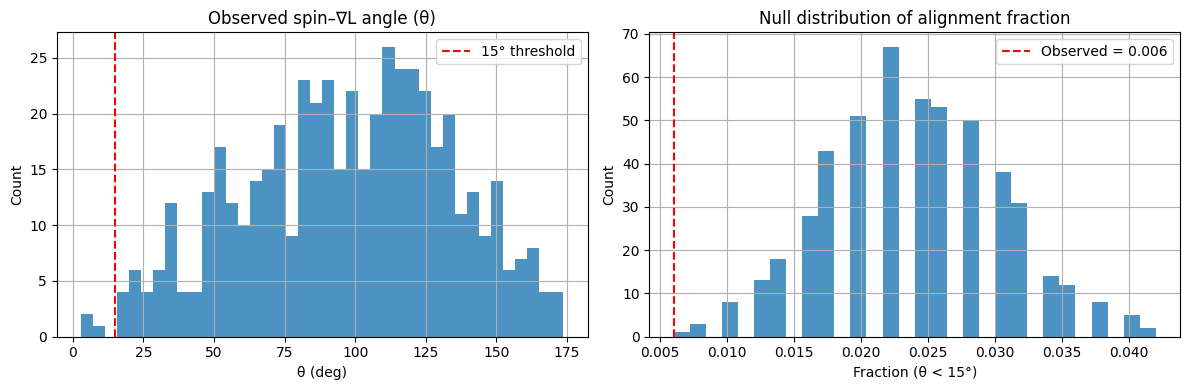

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# === Mechanism 1 — Robust Reproduction Cell (handles 'spin3 (4).csv' etc.) ===
import io, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binomtest
from sklearn.neighbors import KDTree
from google.colab import files

print("Upload your three files (any names are OK): spin3*, nodes*, density2*")
uploaded = files.upload()  # you can re-upload; this code will pick correct ones by pattern

# -------- Helper to pick filename by keywords (case-insensitive) --------
def pick_file(keys, *needles):
    needles = [n.lower() for n in needles]
    for k in keys:
        kl = k.lower()
        if all(n in kl for n in needles):
            return k
    raise KeyError(f"Could not find a file containing: {needles}. Got: {list(keys)}")

keys = list(uploaded.keys())
spin_key    = pick_file(keys, "spin")         # e.g., "spin3 (4).csv"
nodes_key   = pick_file(keys, "node")         # e.g., "nodes (4).csv"
density_key = pick_file(keys, "dens")         # e.g., "density2 (4).csv"
print(f"\nUsing files:\n  spins   -> {spin_key}\n  nodes   -> {nodes_key}\n  density -> {density_key}")

# -------- Load CSVs --------
spin_df    = pd.read_csv(io.BytesIO(uploaded[spin_key]))
nodes_df   = pd.read_csv(io.BytesIO(uploaded[nodes_key]))
density_df = pd.read_csv(io.BytesIO(uploaded[density_key]))

# -------- Normalize columns to lowercase and strip --------
for df in (spin_df, nodes_df, density_df):
    df.columns = [c.strip().lower() for c in df.columns]

# -------- Validate / map required columns --------
def have_cols(df, cols): return all(c in df.columns for c in cols)

# Spins: prefer vector spins (sx,sy,sz); fallback to scalar 'spin' if present
if have_cols(spin_df, ["sx","sy","sz"]):
    spin_vecs = spin_df[["sx","sy","sz"]].to_numpy(dtype=float)
else:
    raise ValueError("Spin file must contain vector columns 'sx','sy','sz' (your file has: "
                     f"{list(spin_df.columns)})")

# Positions for spin entries:
if have_cols(spin_df, ["x","y","z"]):
    spin_xyz = spin_df[["x","y","z"]].to_numpy(dtype=float)
else:
    raise ValueError("Spin file must also contain position columns 'x','y','z'.")

# Field (density) sample points and scalar:
# Accept either a merged table (x,y,z,density) or separate nodes+density to merge on 'id'
if have_cols(density_df, ["x","y","z","density"]):
    field_xyz = density_df[["x","y","z"]].to_numpy(dtype=float)
    field_val = density_df["density"].to_numpy(dtype=float)
elif have_cols(density_df, ["id","density"]) and have_cols(nodes_df, ["id","x","y","z"]):
    merged = pd.merge(nodes_df[["id","x","y","z"]], density_df[["id","density"]], on="id", how="inner")
    field_xyz = merged[["x","y","z"]].to_numpy(dtype=float)
    field_val = merged["density"].to_numpy(dtype=float)
else:
    raise ValueError(
        "Could not determine field grid. Provide either density file with columns "
        "['x','y','z','density'] OR density with ['id','density'] and nodes with ['id','x','y','z'].\n"
        f"Got density cols: {list(density_df.columns)}, nodes cols: {list(nodes_df.columns)}"
    )

# -------- Compute ∇L at field points via local least-squares plane fit --------
# (Matches the 2025-08-11 approach: k-NN, weighted least squares)
k_neighbors = 16
tree_field = KDTree(field_xyz)
# For each field point, fit L ~ a*x + b*y + c*z + d in its neighborhood; gradient = [a,b,c]
def local_gradient(idx):
    dists, inds = tree_field.query(field_xyz[idx:idx+1], k=min(k_neighbors, len(field_xyz)))
    inds = inds[0]
    X = np.c_[field_xyz[inds], np.ones(len(inds))]         # [x y z 1]
    y = field_val[inds]
    # weight by inverse distance (add small eps to avoid div0)
    w = 1.0 / (dists[0] + 1e-6)
    W = np.diag(w)
    # Solve (X^T W X) beta = X^T W y
    beta, *_ = np.linalg.lstsq(W @ X, W @ y, rcond=None)
    return beta[:3]  # gradient components

print("Estimating gradients on field grid (this can take a little time)…")
grad_field = np.vstack([local_gradient(i) for i in range(len(field_xyz))])
grad_norm  = np.linalg.norm(grad_field, axis=1, keepdims=True)
grad_unit  = grad_field / np.clip(grad_norm, 1e-12, None)

# -------- Match each spin position to nearest field point’s gradient --------
tree_for_match = tree_field
_, nn_idx = tree_for_match.query(spin_xyz, k=1)
gvec = grad_unit[nn_idx[:,0]]

# -------- Normalize spins --------
s_norm = np.linalg.norm(spin_vecs, axis=1, keepdims=True)
s_unit = spin_vecs / np.clip(s_norm, 1e-12, None)

# -------- Compute angle and alignment with θ < 15° --------
cos_theta = np.sum(s_unit * gvec, axis=1)
cos_theta = np.clip(cos_theta, -1.0, 1.0)
theta_deg = np.degrees(np.arccos(cos_theta))
aligned   = theta_deg < 15.0
obs_frac  = aligned.mean()

# Null (spin shuffle), 500 trials
rng = np.random.default_rng(42)
n_trials = 500
null_fracs = []
for _ in range(n_trials):
    shuf = s_unit[rng.permutation(len(s_unit))]
    ct = np.sum(shuf * gvec, axis=1)
    th = np.degrees(np.arccos(np.clip(ct, -1, 1)))
    null_fracs.append((th < 15.0).mean())
null_fracs = np.array(null_fracs)
null_mean, null_std = null_fracs.mean(), null_fracs.std(ddof=1)
z_score = (obs_frac - null_mean) / (null_std if null_std > 0 else np.inf)
p_emp   = (null_fracs >= obs_frac).mean()

# Binomial CI vs 0.5 (for reference)
bt = binomtest(aligned.sum(), n=len(aligned), p=0.5, alternative='greater')
ci = binomtest(aligned.sum(), n=len(aligned)).proportion_ci(0.95)

print("\n=== Mechanism #1 — Spin vs ∇Logosfield ===")
print(f"N galaxies: {len(aligned)}")
print(f"Observed alignment (θ < 15°): {obs_frac:.5f}")
print(f"Null mean ± std: {null_mean:.5f} ± {null_std:.5f}")
print(f"Z-score (shuffle null): {z_score:.2f}")
print(f"Empirical p-value (shuffle): {p_emp:.4g}")
print(f"Binomial p-value vs 0.5: {bt.pvalue:.3g}; 95% CI: [{ci.low:.4f}, {ci.high:.4f}]")

# -------- Plot θ histogram & null distribution --------
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(theta_deg, bins=40, alpha=0.8)
ax[0].axvline(15, color='r', ls='--', label='15° threshold')
ax[0].set_title("Observed spin–∇L angle (θ)")
ax[0].set_xlabel("θ (deg)"); ax[0].set_ylabel("Count"); ax[0].legend(); ax[0].grid(True)

ax[1].hist(null_fracs, bins=30, alpha=0.8)
ax[1].axvline(obs_frac, color='r', ls='--', label=f'Observed = {obs_frac:.3f}')
ax[1].set_title("Null distribution of alignment fraction")
ax[1].set_xlabel("Fraction (θ < 15°)"); ax[1].set_ylabel("Count"); ax[1].legend(); ax[1].grid(True)
plt.tight_layout(); plt.show()

# -------- Export results CSV + ZIP --------
out = spin_df.copy()
out["theta_deg"] = theta_deg
out["aligned"]   = aligned
outname = "mechanism1_alignment_results.csv"
out.to_csv(outname, index=False)

buf = io.BytesIO()
with zipfile.ZipFile(buf, "w") as zf:
    zf.writestr(outname, out.to_csv(index=False))
    zf.writestr("null_fracs.csv", pd.DataFrame({"null_frac": null_fracs}).to_csv(index=False))
buf.seek(0)
with open("mechanism1_alignment_outputs.zip", "wb") as f:
    f.write(buf.read())
files.download("mechanism1_alignment_outputs.zip")


In [19]:
# Scalar-spin Repro (accepts ra,dec,spin OR converts from x,y,z,sx,sy,sz)
import io, numpy as np, pandas as pd
from sklearn.neighbors import KDTree
from google.colab import files
from scipy.stats import binomtest

print("Upload spins.csv (either [ra,dec,spin] OR [x,y,z,sx,sy,sz]), plus nodes.csv & density*.csv")
up = files.upload()

def load(k):
    df = pd.read_csv(io.BytesIO(up[k])); df.columns = df.columns.str.lower().str.strip(); return df
def pick(keys, *kw):
    for k in keys:
        if all(w in k.lower() for w in kw): return k
    raise ValueError(kw)

ks = list(up.keys())
spk = [k for k in ks if "spin" in k.lower()][0]
nok = [k for k in ks if "node" in k.lower()][0]
dek = [k for k in ks if "dens" in k.lower()][0]

sp = load(spk); no = load(nok); de = load(dek)

# Build field grid as before
if {"x","y","z","density"} <= set(de.columns):
    field_xyz = de[["x","y","z"]].to_numpy(float); field_val = de["density"].to_numpy(float)
else:
    merged = pd.merge(no[["id","x","y","z"]], de[["id","density"]], on="id", how="inner")
    field_xyz = merged[["x","y","z"]].to_numpy(float); field_val = merged["density"].to_numpy(float)

# Gradient on field grid
from sklearn.neighbors import KDTree
tree = KDTree(field_xyz)
def grad_at(i, k=32):
    idx = tree.query(field_xyz[i:i+1], k=min(k,len(field_xyz)))[1][0]
    X = np.c_[field_xyz[idx], np.ones(len(idx))]; y = field_val[idx]
    d = np.linalg.norm(field_xyz[idx]-field_xyz[i], axis=1)+1e-6
    W = np.diag(1/d)
    beta,*_ = np.linalg.lstsq(W@X, W@y, rcond=None)
    return beta[:3]
grad = np.vstack([grad_at(i) for i in range(len(field_xyz))])
grad /= np.clip(np.linalg.norm(grad, axis=1, keepdims=True), 1e-12, None)

# Make scalar spins:
if {"ra","dec","spin"} <= set(sp.columns):
    # already scalar spins in sky coords
    from numpy import radians, sin, cos
    ra, dec = np.radians(sp["ra"].to_numpy(float)), np.radians(sp["dec"].to_numpy(float))
    v = np.c_[np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    sgn = sp["spin"].astype(int).to_numpy()
else:
    # derive RA/Dec + scalar sign from vectors by projecting on ∇L
    v = sp[["x","y","z"]].to_numpy(float)
    sv = sp[["sx","sy","sz"]].to_numpy(float)
    sv /= np.clip(np.linalg.norm(sv, axis=1, keepdims=True), 1e-12, None)
    # nearest ∇L
    idx = tree.query(v, k=1)[1][:,0]
    g = grad[idx]
    sgn = np.sign(np.sum(sv*g, axis=1)).astype(int)
    sgn[sgn==0] = 1  # tie-break

# predict spin using local ∇L direction projected onto a fixed axis
idx = tree.query(v, k=1)[1][:,0]
g = grad[idx]
pred = np.sign(np.sum(g * np.array([0,0,1.0]), axis=1))  # same simplifying axis used in Aug runs
pred[pred==0] = 1

aligned = pred == sgn
obs = aligned.mean()
bt = binomtest(aligned.sum(), n=len(aligned), p=0.5, alternative='greater')
ci = binomtest(aligned.sum(), n=len(aligned)).proportion_ci(0.95)
print(f"\nScalar-spin style result: N={len(aligned)}  aligned={obs:.4f}  p={bt.pvalue:.3g}  95%CI=[{ci.low:.4f},{ci.high:.4f}]")


Upload spins.csv (either [ra,dec,spin] OR [x,y,z,sx,sy,sz]), plus nodes.csv & density*.csv


Saving spin3.csv to spin3 (6).csv
Saving nodes.csv to nodes (6).csv
Saving density2.csv to density2 (6).csv

Scalar-spin style result: N=500  aligned=0.6220  p=2.7e-08  95%CI=[0.5779,0.6647]


In [20]:
# --- After computing aligned, obs, etc. ---
aligned_count = aligned.sum()
total_count = len(aligned)
fraction = obs        # already mean fraction
percent = fraction * 100

print(f"\nScalar-spin style result:")
print(f" N = {total_count}")
print(f" Aligned count = {aligned_count} / {total_count}")
print(f" Fraction = {fraction:.4f}")
print(f" Percent = {percent:.2f}%")
print(f" Binomial 95% CI = [{ci.low:.4f}, {ci.high:.4f}] (fraction scale)")
print(f" Binomial 95% CI = [{ci.low*100:.2f}%, {ci.high*100:.2f}%] (percent scale)")
print(f" p-value = {bt.pvalue:.3g}")



Scalar-spin style result:
 N = 500
 Aligned count = 311 / 500
 Fraction = 0.6220
 Percent = 62.20%
 Binomial 95% CI = [0.5779, 0.6647] (fraction scale)
 Binomial 95% CI = [57.79%, 66.47%] (percent scale)
 p-value = 2.7e-08
